Qualitative Analysis
1. Annotation - Identify patterns in misclassified text
2. Frequency analysis - Frequency distribution of prediction probability; Determine high probability and low probability thresholds
3. PCA analysis - Type 1 and Type 2 error PCA (annotation as features)

1. Annotation

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm

In [37]:
# import misclassified text with annotated labels
anno = pd.read_csv('misclassified_annotation.csv')
anno.head()

,Unnamed: 0,question,responses,actual_label,pred_label,pred_probability,Sensi_cont,emoji_char,spchar_noeng,neg_notion,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence
0,2530,Would my dead body decompose if sent into spac...,Solar radiation would likely pick you apart sl...,Real,Fake,0.502060,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
1,3805,why diffrent alcohols effect me . I can drink ...,* different * affect * just rewrite that sentence,Real,Fake,0.506464,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,1990,What happens to someone in a wheelchair when t...,How do the other prisoners treat them ?,Real,Fake,0.506785,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,2125,Why does store bought orange juice ( e.g. Trop...,"pasteurization , poor quality fruit , and unme...",Real,Fake,0.508209,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0
4,1874,How does my ISP ( Suddenlink ) know when I 've...,They recieved a letter from the studio that cl...,Real,Fake,0.509648,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0


In [38]:
# initial cleaning
anno.rename(columns={"Unnamed: 0" :'id'}, inplace=True )
anno.columns = anno.columns.str.lower()

# combine sensitive_content with neg_notion
anno['sensi_cont'] = np.where((anno['sensi_cont'] == 1)|(anno['neg_notion'] == 1),1,0)
anno.drop(columns=['neg_notion'],inplace=True)

# creat column to determine if the input text length is short (here we define short as shorter than the average misclassified text)
def get_tokens(col):
     col_token = nltk.word_tokenize(col)
     return len(col_token)
anno['short_text'] = anno['responses'].apply(get_tokens)
anno['short_text'] = np.where(anno['short_text']<=anno['short_text'].mean(),1,0)

# create column to categorize false positive and false negative
anno['type1'] = np.where(((anno['actual_label']=="Fake")&(anno['pred_label'] == "Real")), 1, 0)
anno['type2'] = np.where(((anno['actual_label']=='Real')&(anno['pred_label']=='Fake')),1,0)
# fill na with 0
anno.iloc[:,6:] = anno.iloc[:,6:].fillna(value=0)
anno.head()

,id,question,responses,actual_label,pred_label,pred_probability,sensi_cont,emoji_char,spchar_noeng,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence,short_text,type1,type2
0,2530,Would my dead body decompose if sent into spac...,Solar radiation would likely pick you apart sl...,Real,Fake,0.502060,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1
1,3805,why diffrent alcohols effect me . I can drink ...,* different * affect * just rewrite that sentence,Real,Fake,0.506464,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,1
2,1990,What happens to someone in a wheelchair when t...,How do the other prisoners treat them ?,Real,Fake,0.506785,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,1
3,2125,Why does store bought orange juice ( e.g. Trop...,"pasteurization , poor quality fruit , and unme...",Real,Fake,0.508209,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,0,1
4,1874,How does my ISP ( Suddenlink ) know when I 've...,They recieved a letter from the studio that cl...,Real,Fake,0.509648,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,1


2. Fequency Analysis

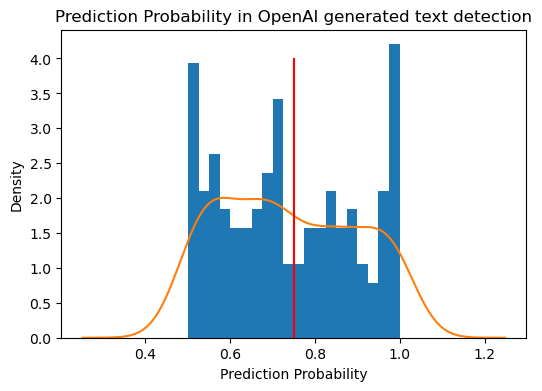

In [39]:
fig, ax = plt.subplots(figsize = (6,4))

# Plots #
    # Plot histogram
anno['pred_probability'].plot(kind = "hist", density = True, bins = 20) # change density to true, because KDE uses density
    # Plot KDE
anno['pred_probability'].plot(kind = "kde")

# X #
ax.set_xlabel("Prediction Probability")
plt.vlines(x=0.75,ymin=0,ymax=4,colors='red')

# Overall #
ax.set_title("Prediction Probability in OpenAI generated text detection")

plt.show()

Looks like the cutoff is around 0.8 but blow 0.8
Elbow method to determine cuttoff at 0.75

{'whiskers': [<matplotlib.lines.Line2D at 0x2c4c6b732e0>,
 'caps': [<matplotlib.lines.Line2D at 0x2c4c6b737f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c4c6b73640>],
 'medians': [<matplotlib.lines.Line2D at 0x2c4c6b89700>],
 'fliers': [<matplotlib.lines.Line2D at 0x2c4c6b89550>],
 'means': [<matplotlib.lines.Line2D at 0x2c4c6b89070>]}

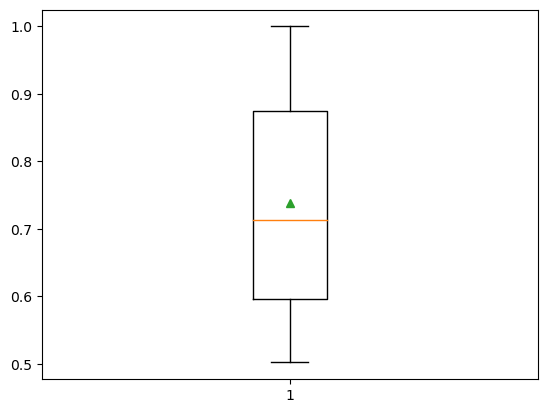

In [40]:
plt.boxplot(anno['pred_probability'],showmeans=True)

What are they getting wrong?
- High probability errors (pred_probability > 0.75)
- Low probability errors (pred_probability <= 0.75)

In [41]:
low_prob = anno.loc[anno['pred_probability']<=0.75]
high_prob = anno.loc[anno['pred_probability']>0.75]

print("There are {} observations in the low probability group and {} observations in the high probability group".format(low_prob.shape[0],high_prob.shape[0]))

There are 85 observations in the low probability group and 68 observations in the high probability group


In [42]:
low_prob.describe()

,id,pred_probability,sensi_cont,emoji_char,spchar_noeng,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence,short_text,type1,type2
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,2195.541176,0.614747,0.247059,0.011765,0.188235,0.094118,0.294118,0.047059,0.176471,0.376471,0.647059,0.741176,0.082353,0.917647
std,1202.570685,0.075823,0.433861,0.108465,0.393220,0.293725,0.458349,0.213021,0.383482,0.487376,0.480721,0.440588,0.276533,0.276533
min,4.000000,0.502060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1106.000000,0.547247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2232.000000,0.607411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,3331.000000,0.685160,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,3954.000000,0.744573,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
high_prob.describe()

,id,pred_probability,sensi_cont,emoji_char,spchar_noeng,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence,short_text,type1,type2
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,2045.867647,0.893825,0.117647,0.014706,0.352941,0.117647,0.250000,0.073529,0.191176,0.264706,0.838235,0.632353,0.323529,0.676471
std,1217.803417,0.077400,0.324585,0.121268,0.481438,0.324585,0.436232,0.262944,0.396151,0.444457,0.370973,0.485750,0.471301,0.471301
min,13.000000,0.751242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,785.000000,0.828247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,2274.500000,0.892526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,2961.250000,0.970591,0.000000,0.000000,1.000000,0.000000,0.250000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,3995.000000,0.999803,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


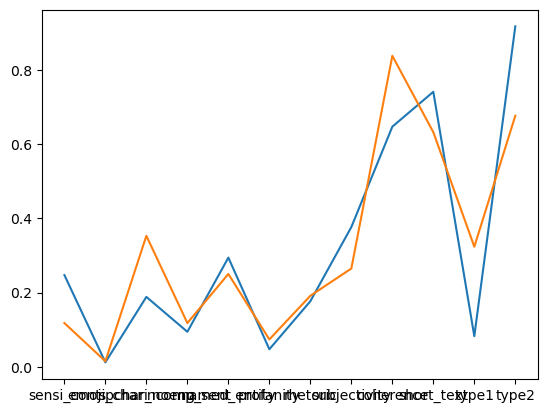

In [44]:
plt.plot(low_prob.iloc[:,6:].mean())
plt.plot(high_prob.iloc[:,6:].mean())

PCA Analysis 
1. Analyze the features in low end and high end probabilities
2. Analyze the features in type1 and type2 errors

1. What are the expressive features in the two ends of probabilities
- 1.a. Low end of prediction probability

In [45]:
low_prob_pca = low_prob.iloc[:,6:-2]

scaler = StandardScaler()
scaler.fit(low_prob_pca)
X_low = scaler.transform(low_prob_pca)

pca = PCA(n_components = 10)
x_low_pca = pca.fit_transform(X_low)

print(x_low_pca,x_low_pca.shape)

[[-5.55198269e-01 -1.81059565e+00 -1.08661217e-03 -6.97436592e-01
  -9.96310462e-02  5.64202166e-01 -6.24091956e-01 -6.12691599e-01
  -6.37414112e-01 -4.15199620e-02]
 [-1.85672974e-01  9.54424474e-01 -1.11971674e+00  1.59083265e+00
   3.04044034e+00 -8.15957246e-01 -1.68230019e+00  1.44219356e-01
  -2.54484148e-01 -4.34171029e-01]
 [ 1.55864798e+00 -7.00925576e-01 -1.15874886e-01 -2.13387325e+00
   7.35994674e-01  6.44536524e-01 -6.30587188e-01  8.34085094e-01
  -1.12961905e+00 -7.07331780e-01]
 [-1.04509121e+00 -2.38355387e+00 -1.50180498e+00  3.78183459e-01
   1.67538716e+00 -5.63238911e-01 -1.45231462e+00  8.19968524e-01
   1.27822010e-01  3.35706857e-02]
 [-2.37489369e+00  2.31074128e+00 -6.79537864e-02  5.57042069e-02
  -5.08480681e-01  1.27929834e-01 -1.78043750e-01  4.37669115e-02
  -3.59669975e-01  8.77299811e-02]
 [ 3.26153212e-01 -1.73768193e+00 -7.98595683e-01 -2.94604599e-01
  -7.88315844e-01 -2.67942494e-01  1.01832133e-01 -7.75661896e-01
  -7.81671839e-01  9.27265634e-01

In [46]:
feature_names = low_prob_pca.columns.to_list()
feature_names

['sensi_cont',
 'emoji_char',
 'spchar_noeng',
 'incomp_sent',
 'named_entity',
 'profanity',
 'rhetoric',
 'subjectivity',
 'coherence',
 'short_text']

In [47]:
pca.explained_variance_ratio_


array([0.19420231, 0.14903396, 0.12198073, 0.11399187, 0.10349489,
       0.09231516, 0.07555984, 0.06944056, 0.05607409, 0.02390659])

In [48]:
pca.explained_variance_ratio_
# Check loadings by each column used for PCA
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(pca.explained_variance_ratio_) + 1)],
    index=feature_names
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
sensi_cont,-0.122086,-0.614246,-0.373828,-0.385056,-0.234384,-0.051758,-0.291793,0.037485,-0.432402,-0.023489
emoji_char,0.288535,0.012217,-0.155458,0.537193,-0.318463,0.625949,-0.211103,0.275905,-0.033889,0.026304
spchar_noeng,-0.311818,0.747267,-0.065093,0.139049,0.257005,0.002324,-0.237651,-0.161751,-0.397514,0.161179
incomp_sent,-0.200526,-0.205450,-0.486840,0.337316,0.530400,-0.318179,-0.211463,0.350664,0.168313,0.010784
named_entity,-0.273090,0.478005,-0.032238,-0.235063,-0.559552,-0.284560,-0.386767,0.183315,0.274361,-0.002004
profanity,0.023315,-0.163193,0.726826,0.334772,-0.112097,-0.379482,-0.007479,0.344632,-0.262574,0.006074
rhetoric,0.474189,0.228495,0.056493,-0.608672,0.251266,0.170729,0.100644,0.487396,-0.037036,0.140810
subjectivity,0.598605,0.043383,-0.429284,0.209616,-0.341463,-0.389672,0.307539,-0.066188,-0.052648,0.230861
coherence,-0.821671,-0.364789,0.131763,-0.025758,-0.093684,0.176915,0.128878,0.031420,0.130755,0.333011
short_text,0.629362,-0.296196,0.308239,-0.033408,0.171369,-0.033685,-0.512570,-0.284107,0.165803,0.174677


In [49]:
pca9_np1=np.reshape(pca.components_[0,:],(10,1))
pca9_np2=np.reshape(pca.components_[1,:],(10,1))
pca9_np3=np.reshape(pca.components_[2,:],(10,1))

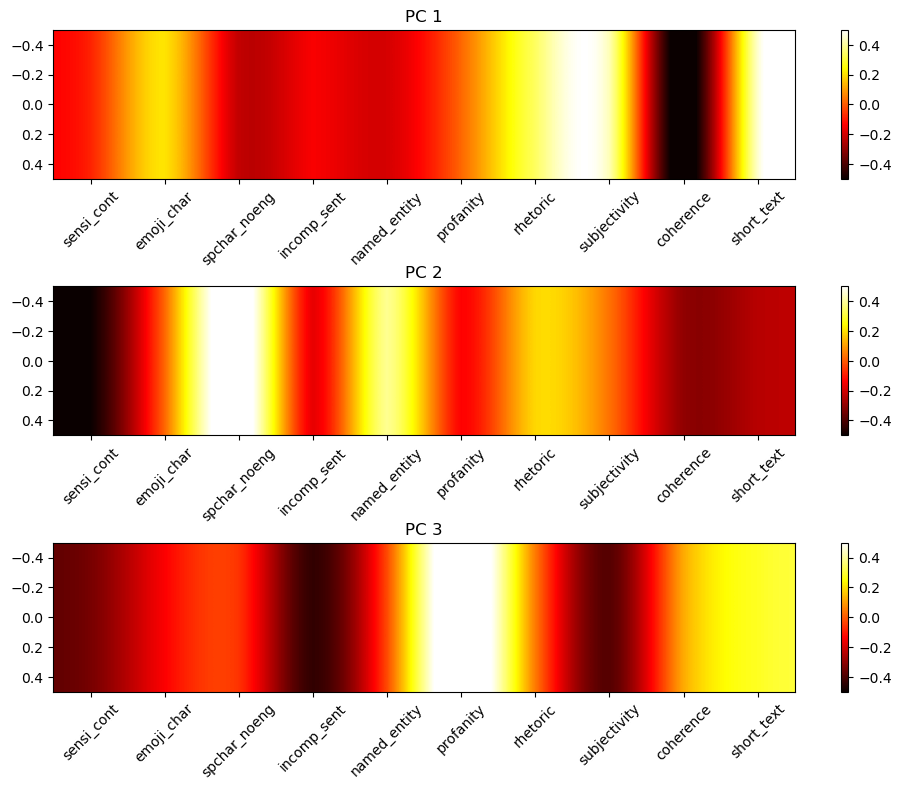

In [50]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(10,9))
# fig.tight_layout(h_pad=2)

im=ax1.imshow(np.transpose(pca9_np1),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax1.set_title('PC 1')
fig.colorbar(im, ax=ax1)
ax1.set_xticks(np.arange(0,10,1))
ax1.set_xticklabels(feature_names,rotation=45)

im2=ax2.imshow(np.transpose(pca9_np2),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax2.set_title('PC 2')
fig.colorbar(im2, ax=ax2)
ax2.set_xticks(np.arange(0,10,1))
ax2.set_xticklabels(feature_names,rotation=45)

im3=ax3.imshow(np.transpose(pca9_np3),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax3.set_title('PC 3')
fig.colorbar(im3, ax=ax3)
ax3.set_xticks(np.arange(0,10,1))
ax3.set_xticklabels(feature_names,rotation=45)
fig.tight_layout()
plt.subplots_adjust(top=0.85)

- 1.b High end of prediction probability

In [51]:
high_prob_pca = high_prob.iloc[:,6:-2]

scaler = StandardScaler()
scaler.fit(high_prob_pca)
X_high = scaler.transform(high_prob_pca)

pca2 = PCA(n_components = 10)
x_high_pca = pca2.fit_transform(X_high)

print(x_high_pca,x_high_pca.shape)

[[-0.88986505 -1.34045299 -1.06478166  0.14333803  1.4506452   1.07896827
  -0.26794277  0.61534712  2.73951685  0.40521542]
 [ 2.40156559  1.30754442 -0.93188857  1.63823061 -0.70295181  0.58149946
  -0.77991307  0.01708768  0.23424793 -0.39830858]
 [-0.8200693   1.50679983 -0.75482861 -0.47473838 -0.0295987   0.98178392
  -1.11954415 -0.28078237 -0.72142096  0.09740618]
 [ 0.01897413  0.20235323  0.2956269  -0.69123448  0.47818733 -0.79935329
  -0.60663242 -0.20060053  0.84579857  0.112835  ]
 [-0.26363371 -0.00719634  0.44269615  1.59512436  1.76443939  0.0059204
  -2.1053408  -0.673106   -1.3499982   0.11205158]
 [ 2.50380911  0.05002963 -0.58451707  0.75923772 -0.88093937 -0.26130514
   0.10872914 -0.79763003  1.03348185 -0.5167009 ]
 [-0.85868746 -0.08714131  0.51643544  0.06193124 -0.26819442 -1.2538315
   0.18013431  0.64474945  0.46288444 -0.65358884]
 [ 1.83682185 -1.54606067  2.46611735  1.0578236   0.86375384  1.30192181
  -0.38445242 -1.43531172 -0.53098934 -1.0317493 ]
 [

In [55]:
pca2.explained_variance_ratio_


array([0.1870676 , 0.14243286, 0.12484894, 0.11811928, 0.1163134 ,
       0.082856  , 0.07451599, 0.06219562, 0.05740459, 0.03424573])

In [52]:
pca2.explained_variance_ratio_
# Check loadings by each column used for PCA
loadings2 = pd.DataFrame(
    data=pca2.components_.T * np.sqrt(pca2.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(pca2.explained_variance_ratio_) + 1)],
    index=feature_names
)
loadings2

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
sensi_cont,-0.080072,-0.568307,0.179323,0.496474,0.387960,-0.011089,-0.170935,-0.329505,-0.343449,-0.022637
emoji_char,-0.016380,0.523778,-0.030467,0.151054,0.587680,-0.026120,0.588897,-0.151688,-0.009849,-0.024766
spchar_noeng,-0.485164,0.026966,-0.378216,-0.346644,-0.356070,0.411205,0.156150,-0.339777,-0.280134,-0.037702
incomp_sent,0.460552,-0.374941,-0.346096,-0.391887,0.284043,-0.034060,0.157789,0.375180,-0.375900,0.009027
named_entity,-0.061003,0.654690,-0.169318,0.416738,0.083738,0.334662,-0.334633,0.280288,-0.264159,0.030223
profanity,-0.326851,-0.484150,-0.399692,0.238500,0.275771,0.449568,0.076876,0.169202,0.377270,0.044990
rhetoric,0.192882,-0.110626,0.784298,-0.048987,-0.122451,0.472827,0.233850,0.114464,-0.076889,0.188950
subjectivity,0.512217,-0.055676,-0.389518,0.480633,-0.442449,-0.117134,0.217521,-0.099254,-0.029723,0.314954
coherence,-0.833249,0.020969,0.039711,-0.183638,0.174475,-0.279455,-0.047526,0.091825,-0.077561,0.399549
short_text,0.583094,0.167825,-0.119845,-0.397615,0.391010,0.200950,-0.329901,-0.323839,0.140925,0.217864


In [53]:
pca2_np1=np.reshape(pca2.components_[0,:],(10,1))
pca2_np2=np.reshape(pca2.components_[1,:],(10,1))
pca2_np3=np.reshape(pca2.components_[2,:],(10,1))

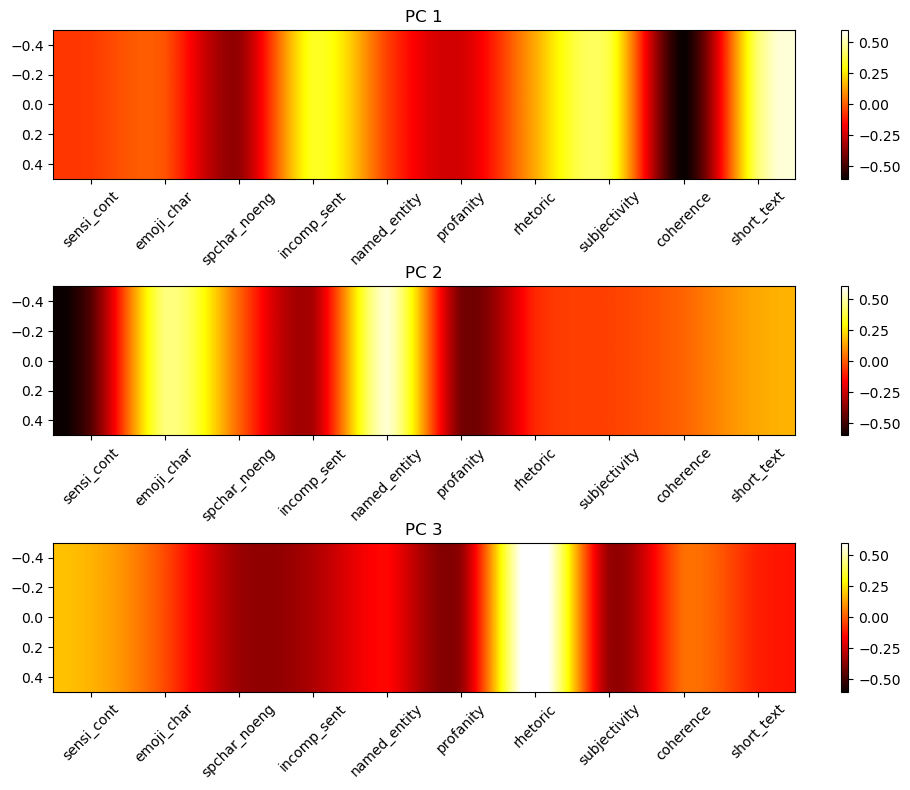

In [57]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(10,9))
# fig.tight_layout(h_pad=2)

im=ax1.imshow(np.transpose(pca2_np1),vmin=-0.6,vmax=0.6, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax1.set_title('PC 1')
fig.colorbar(im, ax=ax1)
ax1.set_xticks(np.arange(0,10,1))
ax1.set_xticklabels(feature_names,rotation=45)

im2=ax2.imshow(np.transpose(pca2_np2),vmin=-0.6,vmax=0.6, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax2.set_title('PC 2')
fig.colorbar(im2, ax=ax2)
ax2.set_xticks(np.arange(0,10,1))
ax2.set_xticklabels(feature_names,rotation=45)

im3=ax3.imshow(np.transpose(pca2_np3),vmin=-0.6,vmax=0.6, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax3.set_title('PC 3')
fig.colorbar(im3, ax=ax3)
ax3.set_xticks(np.arange(0,10,1))
ax3.set_xticklabels(feature_names,rotation=45)
fig.tight_layout()
plt.subplots_adjust(top=0.85)

2. What are the expressive features in Type 1 Errors and Type 2 Errors
- 2.a Type 1 Errors

In [61]:
# Seperate the two dfs
type1 = anno.loc[anno['type1'] == 1]
type2 = anno.loc[anno['type2'] == 1]

type1_pca = type1.iloc[:,6:-2]
type2_pca = type2.iloc[:,6:-2]


In [63]:
scaler = StandardScaler()
scaler.fit(type1_pca)
X_type1 = scaler.transform(type1_pca)

pca3 = PCA(n_components = 10)
x_type1_pca = pca3.fit_transform(X_type1)

print(x_type1_pca,x_type1_pca.shape)

[[-1.64506041e-01 -8.84267450e-01 -6.24513688e-01  2.12662066e-13
  -1.22140472e+00  5.06186378e-01  1.19775584e+00 -8.80524988e-01
  -7.20396124e-02  9.82630316e-17]
 [ 2.22070147e+00 -2.13161093e+00 -4.71152482e-01  2.08686231e-13
  -1.19697099e+00 -3.12315586e-02 -2.33940476e-01  4.81313839e-01
  -3.76780810e-01  3.20705792e-16]
 [-9.47831938e-02  5.03756993e-01 -5.14916535e-01 -4.20021512e-13
   2.40206958e+00  1.58888033e+00  7.49230155e-01  3.38420973e-02
  -5.77986387e-01  4.59205836e-17]
 [ 2.32544152e-01 -7.83027819e-01 -1.71340379e+00  2.04429091e-13
  -1.16092665e+00 -1.62785609e+00 -6.06432824e-02  3.11677300e-01
  -8.38863401e-01 -8.73934857e-17]
 [ 9.12317705e-01 -8.20583151e-01 -2.06489328e-01  2.15796567e-13
  -1.25114196e+00  2.21456142e+00 -1.22783873e-01  1.11455427e+00
   4.12528792e-01 -7.13672892e-17]
 [-1.13961054e+00 -7.19239197e-01 -1.33363837e+00  2.07778337e-13
  -1.18897506e+00 -4.53762913e-01  3.72104623e-01 -6.71977251e-02
   4.72563745e-01 -2.22051483e-17

In [65]:
pca3.explained_variance_ratio_

array([2.02127055e-01, 1.80371461e-01, 1.52965138e-01, 1.15079365e-01,
       1.13460372e-01, 1.02976678e-01, 6.64602216e-02, 4.15782115e-02,
       2.49814975e-02, 6.22854824e-34])

In [66]:
loadings3 = pd.DataFrame(
    data=pca3.components_.T * np.sqrt(pca3.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(pca3.explained_variance_ratio_) + 1)],
    index=feature_names
)
loadings3

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
sensi_cont,0.563284,-6.216631e-01,2.578751e-01,6.498913e-20,-1.505826e-03,2.526796e-01,-3.184980e-01,2.478867e-01,1.967823e-01,-1.769415e-33
emoji_char,0.000000,7.197893e-17,3.977122e-16,-8.440032e-18,-7.237026e-17,1.835544e-16,-4.369204e-17,-1.036754e-16,5.357482e-17,-7.619644e-17
spchar_noeng,-0.665638,1.064185e-01,-4.211082e-01,-2.330054e-15,1.658591e-02,-4.677272e-01,-3.231859e-01,2.518101e-01,1.306967e-01,8.459504e-33
incomp_sent,0.431832,4.360429e-01,-2.624533e-02,7.323606e-01,-2.287271e-03,-1.847750e-01,2.141377e-01,4.007627e-02,2.011296e-01,-2.114876e-33
named_entity,-0.020103,-4.326056e-01,-5.762452e-01,9.728170e-14,-5.606029e-01,1.292183e-01,3.775924e-01,2.047344e-01,-2.527690e-02,-2.114876e-33
profanity,-0.012693,-2.708141e-01,-3.520616e-01,-1.490422e-13,8.617118e-01,1.034083e-01,2.568677e-01,1.369722e-01,-1.681074e-02,-1.480413e-32
rhetoric,-0.314294,-8.421443e-02,8.260754e-01,2.998794e-15,-1.321523e-02,-2.680972e-01,2.766979e-01,3.038608e-01,-8.060323e-02,-1.718337e-33
subjectivity,0.805970,-3.539409e-02,-1.940507e-01,-1.883668e-15,1.234338e-02,-4.922385e-01,-1.457537e-01,1.009328e-01,-2.708052e-01,-1.268926e-32
coherence,-0.431832,-4.360429e-01,2.624533e-02,7.323606e-01,2.287271e-03,1.847750e-01,-2.141377e-01,-4.007627e-02,-2.011296e-01,2.114876e-33
short_text,0.043112,7.965114e-01,-6.769217e-02,1.786363e-15,-1.323111e-02,5.171314e-01,-1.246647e-01,3.103282e-01,-1.240897e-01,-8.459504e-33


In [67]:
pca3_np1=np.reshape(pca3.components_[0,:],(10,1))
pca3_np2=np.reshape(pca3.components_[1,:],(10,1))
pca3_np3=np.reshape(pca3.components_[2,:],(10,1))

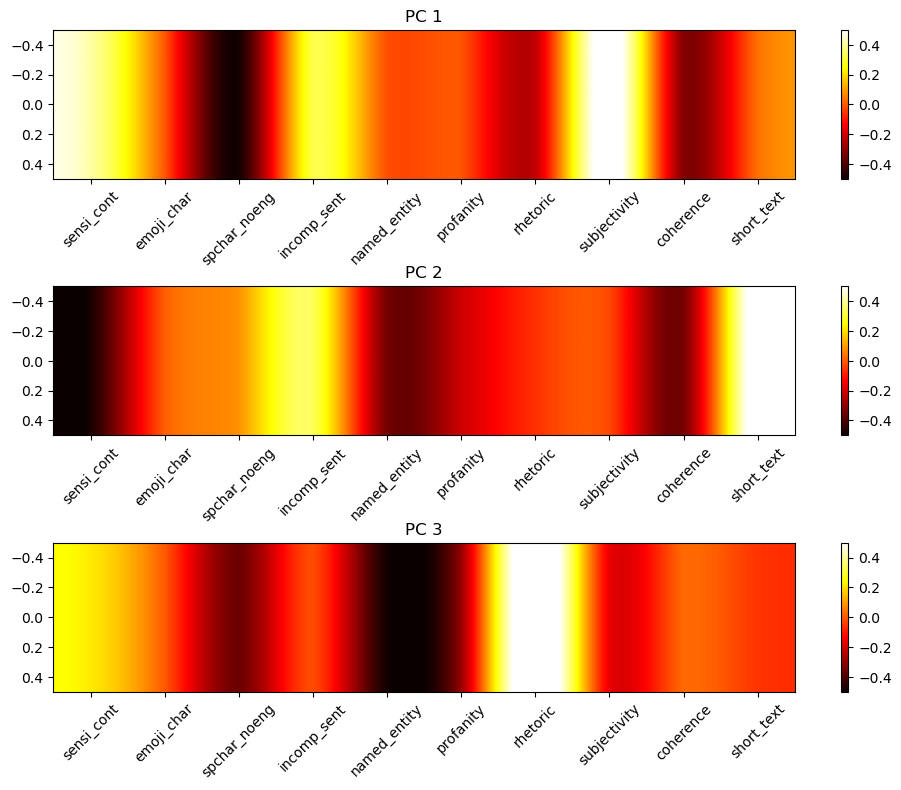

In [69]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(10,9))
# fig.tight_layout(h_pad=2)

im=ax1.imshow(np.transpose(pca3_np1),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax1.set_title('PC 1')
fig.colorbar(im, ax=ax1)
ax1.set_xticks(np.arange(0,10,1))
ax1.set_xticklabels(feature_names,rotation=45)

im2=ax2.imshow(np.transpose(pca3_np2),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax2.set_title('PC 2')
fig.colorbar(im2, ax=ax2)
ax2.set_xticks(np.arange(0,10,1))
ax2.set_xticklabels(feature_names,rotation=45)

im3=ax3.imshow(np.transpose(pca3_np3),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax3.set_title('PC 3')
fig.colorbar(im3, ax=ax3)
ax3.set_xticks(np.arange(0,10,1))
ax3.set_xticklabels(feature_names,rotation=45)
fig.tight_layout()
plt.subplots_adjust(top=0.85)

-2.b Type2 Errors

In [70]:
scaler.fit(type2_pca)
X_type2 = scaler.transform(type2_pca)

pca4 = PCA(n_components = 10)
x_type2_pca = pca4.fit_transform(X_type2)

print(x_type2_pca,x_type2_pca.shape)

[[-0.56718836  1.81055052 -1.25198317 ... -0.65050913  0.8969616
  -0.10391849]
 [ 0.07051506  0.29697803  2.99102229 ... -0.30057953  0.10552205
  -0.84339085]
 [ 1.69789134  1.23415958 -1.50429615 ...  0.6907932   1.20410971
  -0.77901679]
 ...
 [-1.12271636 -1.49987432  1.31352257 ...  0.38825578  1.3150483
   0.86216661]
 [-1.24193059 -2.53271096  0.72392734 ...  0.5835283   0.46776054
   0.8803205 ]
 [ 0.09777392 -1.40469341 -2.21075343 ...  1.59540274  0.56541215
   0.27847462]] (124, 10)


In [71]:
pca4.explained_variance_ratio_

array([0.18298502, 0.13888103, 0.11482685, 0.11037012, 0.10401604,
       0.09345843, 0.08629431, 0.070309  , 0.06841052, 0.03044868])

In [72]:
loadings4 = pd.DataFrame(
    data=pca4.components_.T * np.sqrt(pca4.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(pca4.explained_variance_ratio_) + 1)],
    index=feature_names
)
loadings4

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
sensi_cont,-0.025577,0.594623,-0.365898,-0.086379,-0.266178,-0.321539,-0.382968,0.093914,0.426739,-0.026980
emoji_char,0.125880,-0.132590,-0.168621,0.722574,-0.161571,0.534303,-0.117756,0.247920,0.192257,0.016678
spchar_noeng,-0.350052,-0.485552,0.479890,-0.145929,0.212954,0.048168,-0.303806,-0.098870,0.486597,0.108274
incomp_sent,-0.059013,0.429146,0.633346,-0.061422,-0.193070,0.163487,-0.432095,0.242503,-0.324499,0.027640
named_entity,-0.072233,-0.545193,-0.282991,0.253031,0.103991,-0.430052,-0.511740,0.073341,-0.313899,0.004487
profanity,-0.083732,0.323392,0.231229,0.382794,0.638002,-0.345747,0.210687,0.342970,0.088783,-0.007101
rhetoric,0.484684,-0.109356,-0.307151,-0.530799,0.326703,0.240347,-0.088972,0.426444,-0.000641,0.175761
subjectivity,0.638269,-0.177813,0.275854,0.142501,-0.435897,-0.382274,0.203034,0.080310,0.073771,0.288911
coherence,-0.855215,0.187301,-0.242499,0.054991,-0.044302,0.053410,0.105879,-0.015014,-0.120010,0.386228
short_text,0.562388,0.358526,-0.032782,0.205906,0.390476,0.114142,-0.252600,-0.508332,-0.047566,0.172816


In [73]:
pca4_np1=np.reshape(pca4.components_[0,:],(10,1))
pca4_np2=np.reshape(pca4.components_[1,:],(10,1))
pca4_np3=np.reshape(pca4.components_[2,:],(10,1))

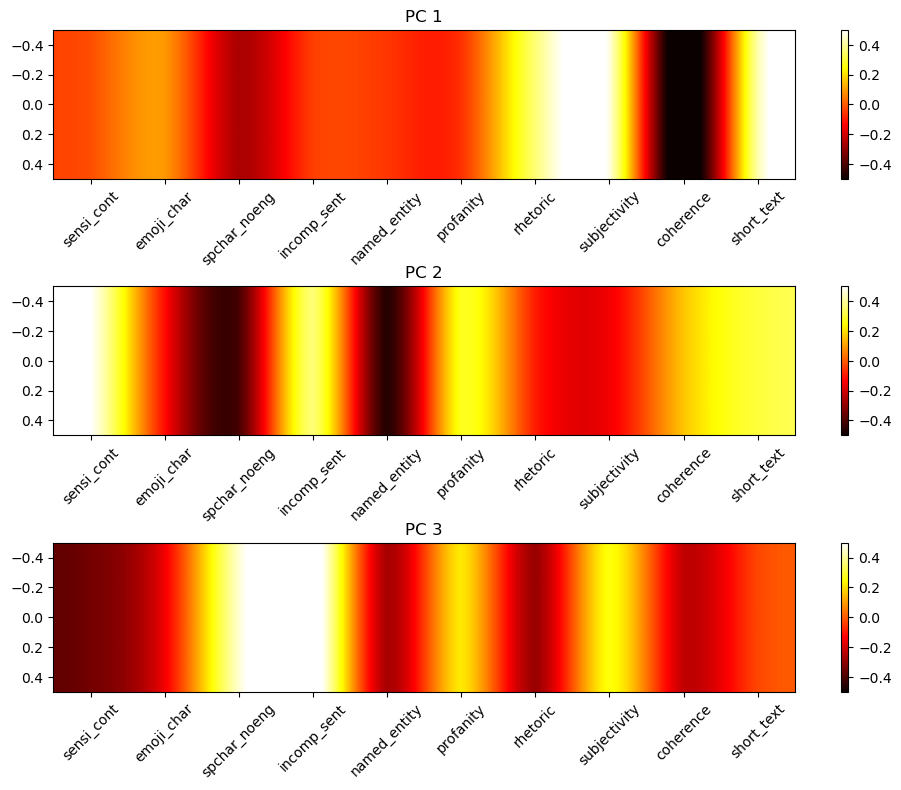

In [74]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(10,9))
# fig.tight_layout(h_pad=2)

im=ax1.imshow(np.transpose(pca4_np1),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax1.set_title('PC 1')
fig.colorbar(im, ax=ax1)
ax1.set_xticks(np.arange(0,10,1))
ax1.set_xticklabels(feature_names,rotation=45)

im2=ax2.imshow(np.transpose(pca4_np2),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax2.set_title('PC 2')
fig.colorbar(im2, ax=ax2)
ax2.set_xticks(np.arange(0,10,1))
ax2.set_xticklabels(feature_names,rotation=45)

im3=ax3.imshow(np.transpose(pca4_np3),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax3.set_title('PC 3')
fig.colorbar(im3, ax=ax3)
ax3.set_xticks(np.arange(0,10,1))
ax3.set_xticklabels(feature_names,rotation=45)
fig.tight_layout()
plt.subplots_adjust(top=0.85)

In [76]:
type1.describe()

,id,pred_probability,sensi_cont,emoji_char,spchar_noeng,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence,short_text,type1,type2
count,29.000000,29.000000,29.000000,29.0,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.0,29.0
mean,2174.172414,0.856142,0.206897,0.0,0.448276,0.034483,0.275862,0.137931,0.172414,0.241379,0.965517,0.413793,1.0,0.0
std,1265.658667,0.158744,0.412251,0.0,0.506120,0.185695,0.454859,0.350931,0.384426,0.435494,0.185695,0.501230,0.0,0.0
min,123.000000,0.513766,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
25%,1291.000000,0.766291,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.0
50%,2407.000000,0.908998,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.0
75%,3203.000000,0.988307,0.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,0.0
max,3995.000000,0.999803,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.0


In [77]:
type2.describe()

,id,pred_probability,sensi_cont,emoji_char,spchar_noeng,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence,short_text,type1,type2
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.0,124.0
mean,2118.459677,0.711335,0.185484,0.016129,0.217742,0.120968,0.274194,0.040323,0.185484,0.346774,0.677419,0.758065,0.0,1.0
std,1198.790755,0.146176,0.390266,0.126483,0.414385,0.327413,0.447917,0.197513,0.390266,0.477874,0.469360,0.429993,0.0,0.0
min,4.000000,0.502060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0
25%,1056.750000,0.583501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0
50%,2202.500000,0.693137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,1.0
75%,3138.250000,0.827269,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.0
max,3954.000000,0.991980,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0
